# PyGMTSAR SBAS and PSI Analyses: Borowa Gora - Poland, 2023

## 1. Load and Setup Python Modules

In [1]:
import platform, sys, os
PATH = os.environ['PATH']
from pygmtsar import __version__
print(__version__)

import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from dask.distributed import Client
import dask
import warnings
warnings.filterwarnings('ignore')

# plotting modules
import pyvista as pv

from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles, XYZTiles, utils

2024.8.30.post5


In [2]:
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension(comms='ipywidgets')
panel.extension('vtk')
from contextlib import contextmanager
import matplotlib.pyplot as plt
@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12



# define Pandas display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

#%matplotlib inline

In [4]:
from os.path import abspath, dirname, join
PROJ_PATH = dirname(abspath(abspath("")))
sys.path.insert(0, PROJ_PATH)

from settings.paths import setup
setup()

## 2. Define Sentinel-1 SLC Scenes and Processing Parameters

In [5]:
# The subswath is required for partial scene downloads and is not used for burst downloads.
# The orbit is used to define directory names.
ORBIT    = 'D' # descending (A for Ascending)
SUBSWATH = 3 # Id of a subswath
REFERENCE = '2023-01-02'

In [6]:
BURSTS = """
S1_327247_IW3_20230219T044442_VV_527E-BURST
S1_327247_IW3_20230207T044442_VV_FA04-BURST
S1_327247_IW3_20230126T044442_VV_C08C-BURST
S1_327247_IW3_20230114T044443_VV_1187-BURST
S1_327247_IW3_20230102T044443_VV_D42C-BURST
"""
BURSTS = list(filter(None, BURSTS.split('\n')))
print (f'Bursts defined: {len(BURSTS)}')

POLAR = 'VV'

Bursts defined: 5


In [7]:
from settings.paths import DATA_DIR
from utils.internal.io.json_io import open_json
from settings.paths import KEYS_DIR
from utils.internal.geo.aoi import get_aoi

main_folder = join(DATA_DIR, 'sar/sbas/desc/2023/bogo_pl_test')

WORKDIR = os.path.join(main_folder, 'raw')
DATADIR = os.path.join(main_folder, 'data')

In [11]:
# define DEM filename inside data directory
DEM = f'{DATADIR}/dem.nc'
aoi_name = 'bogo'
aois_path = join(DATA_DIR, 'polygons/aoi.geojson')

AOI_dict = get_aoi(json_path=aois_path, aoi_name=aoi_name)
AOI = gpd.GeoDataFrame.from_features([AOI_dict])
AOI

,geometry,id,aoiName
0,"MULTIPOLYGON (((20.64924 52.6616, 21.84825 52.54708, 21.83294 52.38683, 20.63394 52.50135, 20.64...",1,bogo


## 3. Download and Unpack Datasets

### Enter Your ASF User and Password

If the data directory is empty or doesn't exist, you'll need to download Sentinel-1 scenes from the Alaska Satellite Facility (ASF) datastore. Use your Earthdata Login credentials. If you don't have an Earthdata Login, you can create one at https://urs.earthdata.nasa.gov//users/new

You can also use pre-existing SLC scenes stored on your Google Drive, or you can copy them using a direct public link from iCloud Drive.

The credentials below are available at the time the notebook is validated.

In [12]:
secrets = open_json(join(KEYS_DIR, 'secrets.json'))

# Set these variables to None and you will be prompted to enter your username and password below.
asf = ASF(secrets['asf']['username'], secrets['asf']['password'])

In [15]:

# Optimized scene downloading from ASF - only the required subswaths and polarizations.
# Subswaths are already encoded in burst identifiers and are only needed for scenes.
#print(asf.download(DATADIR, SCENES, SUBSWATH))

#for burst in BURSTS:
#    print(asf.download(DATADIR, [burst], skip_exist=True, polarization=POLAR, n_jobs=1))

In [17]:
# scan the data directory for SLC scenes and download missed orbits

S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))

0    S1A_OPER_AUX_POEORB_OPOD_20230122T081819_V20230101T225942_20230103T005942.EOF.zip
1    S1A_OPER_AUX_POEORB_OPOD_20230203T080758_V20230113T225942_20230115T005942.EOF.zip
2    S1A_OPER_AUX_POEORB_OPOD_20230215T080722_V20230125T225942_20230127T005942.EOF.zip
3    S1A_OPER_AUX_POEORB_OPOD_20230227T080453_V20230206T225942_20230208T005942.EOF.zip
4    S1A_OPER_AUX_POEORB_OPOD_20230311T080753_V20230218T225942_20230220T005942.EOF.zip
Name: orbit, dtype: object

In [14]:
# download Copernicus Global DEM 1 arc-second

Tiles().download_dem(AOI, filename=DEM)

Tiles Parallel Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

<xarray.DataArray (lat: 989, lon: 2914)> Size: 12MB
array([[ 74.08405 ,  74.514015,  74.30083 , ..., 167.1797  , 167.33603 ,
        168.68814 ],
       [ 74.166725,  74.40476 ,  74.175224, ..., 167.43079 , 167.20592 ,
        167.8572  ],
       [ 74.025795,  74.50418 ,  74.62864 , ..., 166.8471  , 166.98193 ,
        167.1697  ],
       ...,
       [ 93.454765,  92.156105,  91.38244 , ..., 109.67879 , 112.699265,
        111.328255],
       [100.829704, 100.15673 ,  95.32002 , ..., 109.87418 , 112.32008 ,
        111.61313 ],
       [100.742775, 104.79375 , 108.68392 , ..., 107.10224 , 110.31439 ,
        110.9403  ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 23kB 20.63 20.63 20.64 20.64 ... 21.85 21.85 21.85
  * lat      (lat) float64 8kB 52.39 52.39 52.39 52.39 ... 52.66 52.66 52.66
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

## 4. Run Local Dask Cluster

Launch Dask cluster for local and distributed multicore computing. That's possible to process terabyte scale Sentinel-1 SLC datasets on Apple Air 16 GB RAM.

In [8]:
# simple Dask initialization
if 'client' in globals():
    client.close()
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 3.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41477,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 3.79 GiB
Comm: tcp://127.0.0.1:36679,Total threads: 2
Dashboard: http://127.0.0.1:39367/status,Memory: 0.95 GiB
Nanny: tcp://127.0.0.1:33089,


## 5. Init

Search recursively for measurement (.tiff) and annotation (.xml) and orbit (.EOF) files in the DATA directory. It can be directory with full unzipped scenes (.SAFE) subdirectories or just a directory with the list of pairs of required .tiff and .xml files (maybe pre-filtered for orbit, polarization and subswath to save disk space). If orbit files and DEM are missed these will be downloaded automatically below.

### Select Original Secenes and Orbits

Use filters to find required subswath, polarization and orbit in original scenes .SAFE directories in the data directory.

In [9]:
from utils.internal.io.s1_stack import init_stack

In [10]:
sbas = init_stack(
    dem=DEM,
    aoi=AOI,
    ref=REFERENCE,
    data_dir=DATADIR,
    work_dir=WORKDIR,
    verbose=True,
    drop_if_exists=False
)

Scan data directory for S1 scenes: /home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data
Initialize S1 Stack with working directory: /home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/raw
NOTE: auto set reference scene 2023-01-02. You can change it like Stack.set_reference("2022-01-20")
Load DEM /home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/dem.nc from /home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data


Save DEM on WGS84 Ellipsoid:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [11]:
sbas.to_dataframe()

,datetime,orbit,mission,polarization,subswath,datapath,metapath,noisepath,calibpath,orbitpath,geometry
date,,,,,,,,,,,
2023-01-02,2023-01-02 04:44:43,D,S1A,VV,3,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...,None,None,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_OPER_AUX_POEORB_...,"MULTIPOLYGON (((21.89212 52.54494, 21.82631 52.55166, 21.7607 52.55832, 21.6955 52.5649, 21.6306..."
2023-01-14,2023-01-14 04:44:43,D,S1A,VV,3,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...,None,None,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_OPER_AUX_POEORB_...,"MULTIPOLYGON (((21.89429 52.54504, 21.82848 52.55175, 21.76287 52.55841, 21.69767 52.56499, 21.6..."
2023-01-26,2023-01-26 04:44:42,D,S1A,VV,3,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...,None,None,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_OPER_AUX_POEORB_...,"MULTIPOLYGON (((21.89161 52.54495, 21.8258 52.55167, 21.76018 52.55833, 21.69498 52.56491, 21.63..."
2023-02-07,2023-02-07 04:44:42,D,S1A,VV,3,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...,None,None,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_OPER_AUX_POEORB_...,"MULTIPOLYGON (((21.89083 52.5454, 21.82502 52.55211, 21.75941 52.55877, 21.69422 52.56535, 21.62..."
2023-02-19,2023-02-19 04:44:42,D,S1A,VV,3,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...,None,None,/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_OPER_AUX_POEORB_...,"MULTIPOLYGON (((21.89117 52.54496, 21.82536 52.55168, 21.75975 52.55833, 21.69455 52.56491, 21.6..."


In [12]:
vars(sbas)

{'basedir': '/home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/raw',
 'df':                       datetime orbit mission polarization  subswath  \
 date                                                                  
 2023-01-02 2023-01-02 04:44:43     D     S1A           VV         3   
 2023-01-14 2023-01-14 04:44:43     D     S1A           VV         3   
 2023-01-26 2023-01-26 04:44:42     D     S1A           VV         3   
 2023-02-07 2023-02-07 04:44:42     D     S1A           VV         3   
 2023-02-19 2023-02-19 04:44:42     D     S1A           VV         3   
 
                                                                                                        datapath  \
 date                                                                                                              
 2023-01-02  /home/rav_marcin/projects/msg2sar/data/sar/sbas/desc/2023/bogo_pl_test/data/S1A_IW_SLC__1SDV_202...   
 2023-01-14  /home/rav_marcin/projects/msg2sar/dat

In [18]:
from utils.internal.geo.poly import find_rect_in_gdf
# find_rect_in_gdf(sbas.to_dataframe())

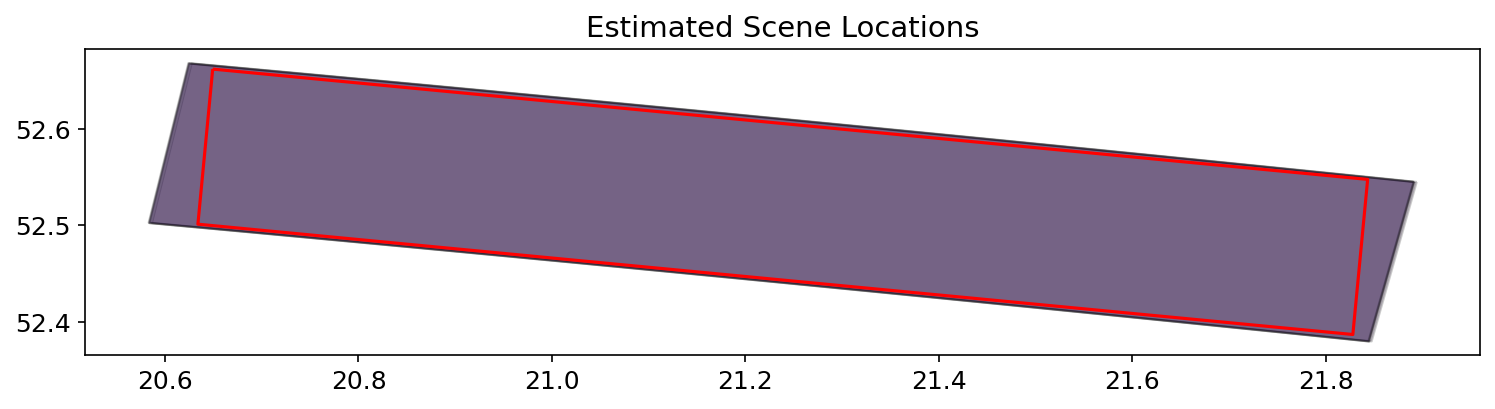

In [14]:
sbas.plot_scenes(AOI=AOI)

## Reframe Scenes (Optional)

Stitch sequential scenes and crop the subswath to a smaller area for faster processing when the full area is not needed.

In [20]:
sbas.compute_reframe(AOI, n_jobs=1)

Reframing:   0%|          | 0/5 [00:00<?, ?it/s]

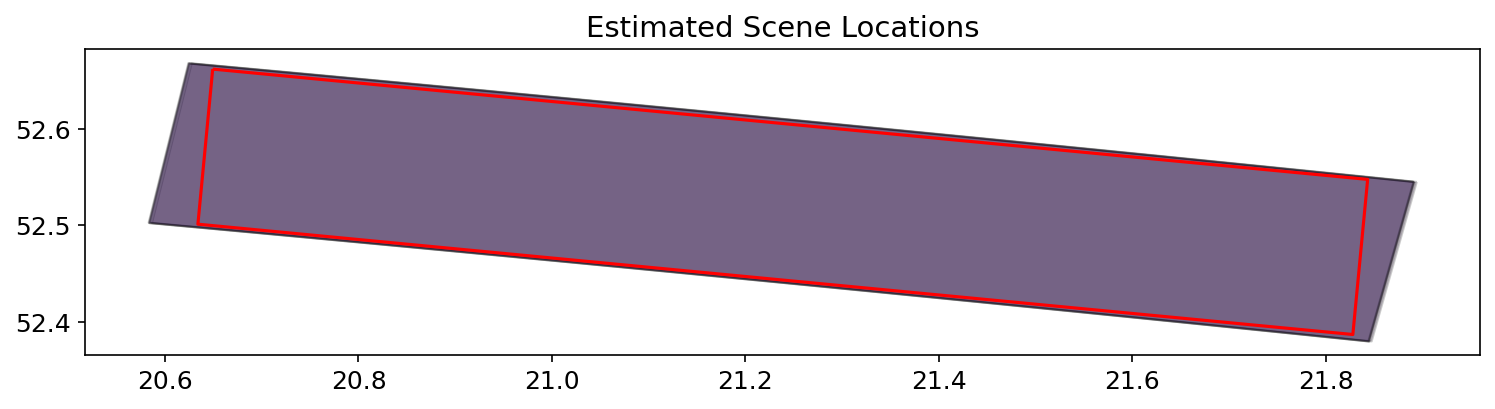

In [21]:
sbas.plot_scenes(AOI=AOI)

### Load DEM

The function below loads DEM from file or Xarray variable and converts heights to ellipsoidal model using EGM96 grid.

In [34]:
# define the area of interest (AOI) to speedup the processing
sbas.load_dem(DEM, AOI)

Save DEM on WGS84 Ellipsoid:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

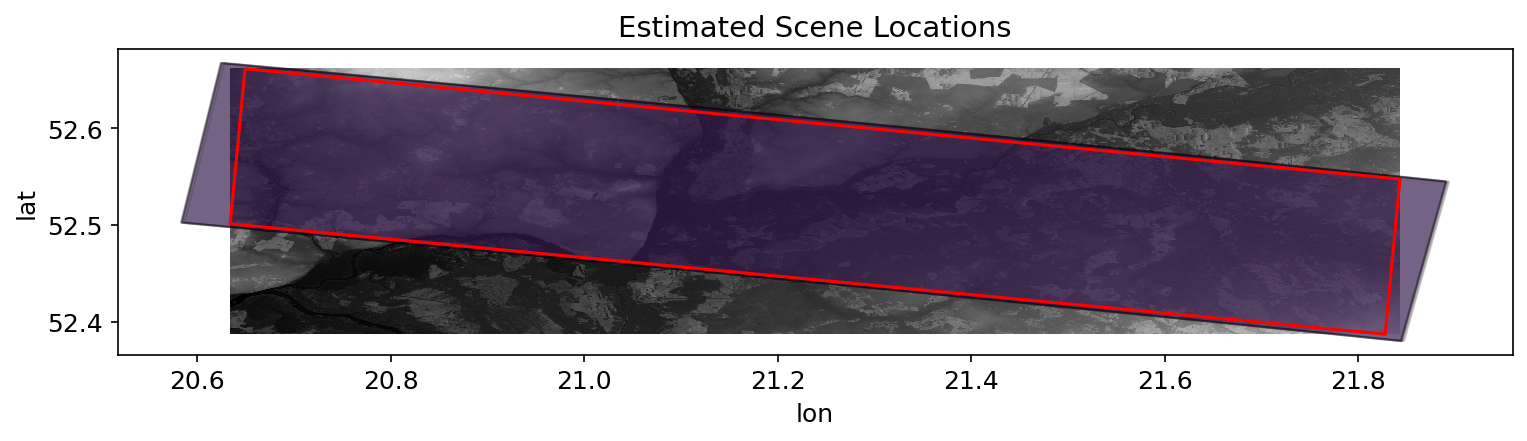

In [25]:
sbas.plot_scenes(AOI=AOI)

## Align Images

In [ ]:
sbas.compute_align()

Preparing Reference:   0%|          | 0/1 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/4 [00:00<?, ?it/s]

## Geocoding Transform

In [ ]:
# use the original Sentinel-1 resolution (1 pixel spacing)
sbas.compute_geocode(1)

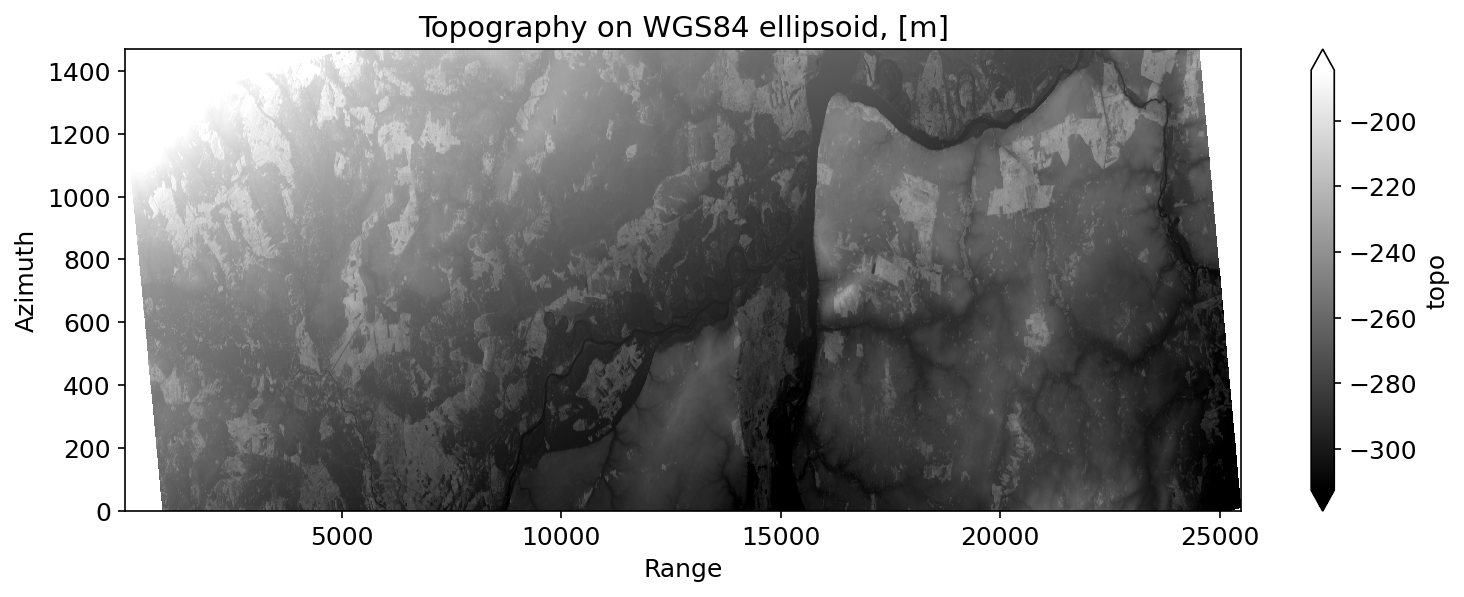

In [15]:
sbas.plot_topo(quantile=[0.01, 0.99])

## Persistent Scatterers Function (PSF)

In [ ]:
# use the only selected dates for the pixels stability analysis
sbas.compute_ps()

In [ ]:
sbas.plot_psfunction(quantile=[0.01, 0.90])

In [ ]:
psmask_sbas = sbas.multilooking(sbas.psfunction(), coarsen=(1,4), wavelength=100)>0.5
topo_sbas = sbas.get_topo().interp_like(psmask_sbas, method='nearest')
landmask_sbas = psmask_sbas&(np.isfinite(topo_sbas))
landmask_sbas = utils.binary_opening(landmask_sbas, structure=np.ones((20,20)))
landmask_sbas = np.isfinite(sbas.conncomp_main(landmask_sbas))
landmask_sbas = utils.binary_closing(landmask_sbas, structure=np.ones((20,20)))
landmask_sbas = np.isfinite(psmask_sbas.where(landmask_sbas))
sbas.plot_landmask(landmask_sbas)

## SBAS Baseline

In [13]:
baseline_pairs = sbas.sbas_pairs(days=60)
# optionally, drop dates having less then 2 pairs
#baseline_pairs = sbas.sbas_pairs_limit(baseline_pairs, limit=2, iterations=2)
# optionally, drop all pairs connected to the specified dates
#baseline_pairs = sbas.sbas_pairs_filter_dates(baseline_pairs, ['2021-01-01'])
baseline_pairs

,ref,rep,ref_baseline,rep_baseline,pair,baseline,duration,rel
0,2023-01-02,2023-01-14,-0.00,-115.89,2023-01-02 2023-01-14,-115.89,12,NaT
1,2023-01-02,2023-01-26,-0.00,37.43,2023-01-02 2023-01-26,37.43,24,NaT
2,2023-01-02,2023-02-07,-0.00,25.24,2023-01-02 2023-02-07,25.24,36,NaT
3,2023-01-02,2023-02-19,-0.00,1.02,2023-01-02 2023-02-19,1.02,48,NaT
4,2023-01-14,2023-01-26,-115.89,37.43,2023-01-14 2023-01-26,153.32,12,NaT
5,2023-01-14,2023-02-07,-115.89,25.24,2023-01-14 2023-02-07,141.13,24,NaT
6,2023-01-14,2023-02-19,-115.89,1.02,2023-01-14 2023-02-19,116.91,36,NaT
7,2023-01-26,2023-02-07,37.43,25.24,2023-01-26 2023-02-07,-12.19,12,NaT
8,2023-01-26,2023-02-19,37.43,1.02,2023-01-26 2023-02-19,-36.41,24,NaT
9,2023-02-07,2023-02-19,25.24,1.02,2023-02-07 2023-02-19,-24.22,12,NaT


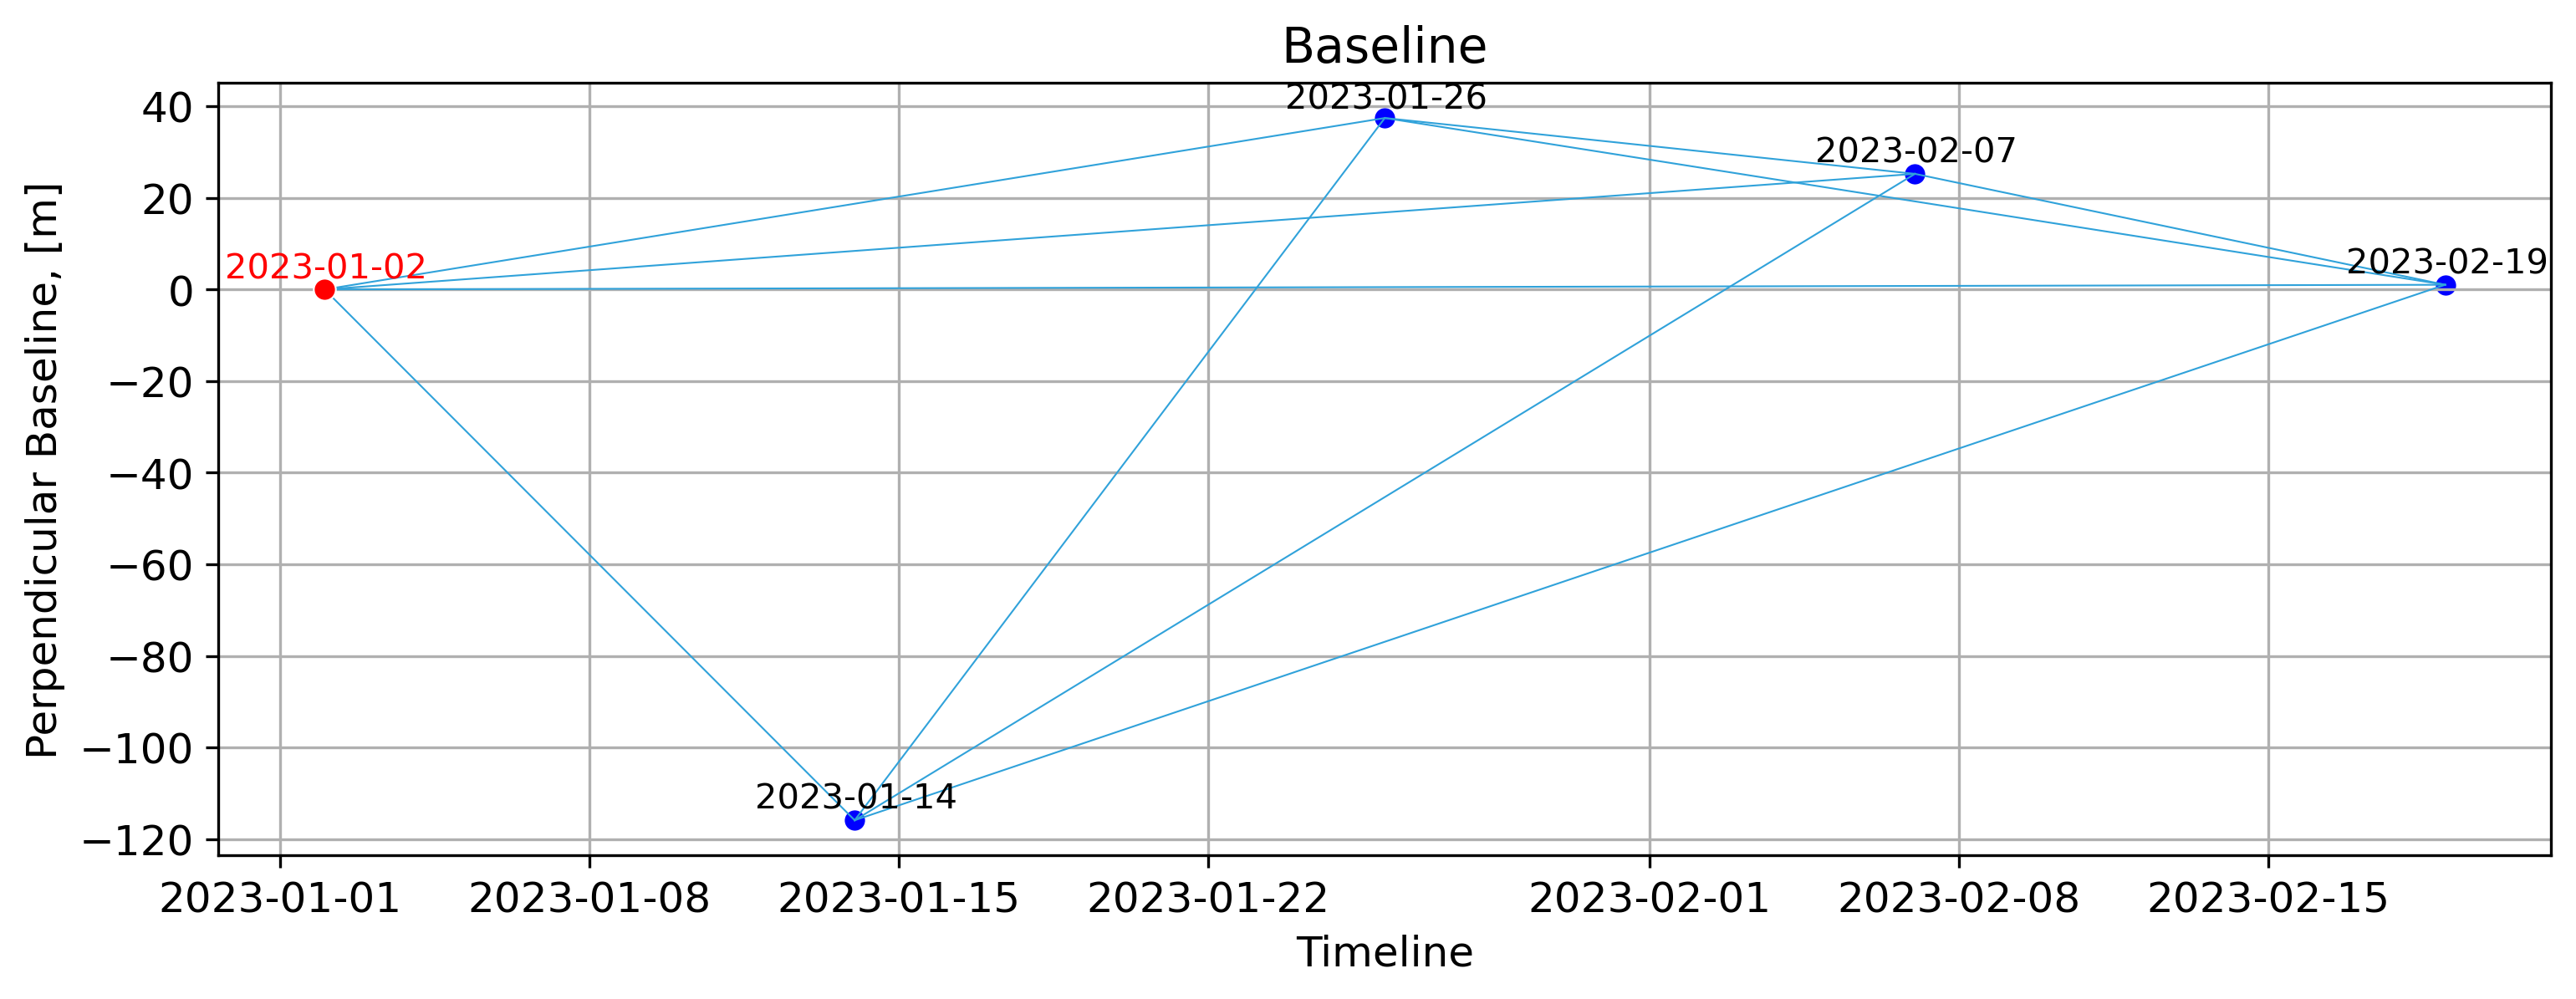

In [14]:
with mpl_settings({'figure.dpi': 300}):
    sbas.plot_baseline(baseline_pairs)

## SBAS Analysis

### Multi-looked Resolution for SBAS

In [ ]:
sbas.compute_interferogram_multilook(baseline_pairs, 'intf_mlook', wavelength=200, psize=32,
                                     weight=sbas.psfunction())

In [ ]:
# optionally, materialize to disk and open
ds_sbas = sbas.open_stack('intf_mlook')
# apply land mask
ds_sbas = ds_sbas.where(landmask_sbas)
intf_sbas = ds_sbas.phase
corr_sbas = ds_sbas.correlation
corr_sbas

In [ ]:
sbas.plot_interferograms(intf_sbas[:8], caption='SBAS Phase, [rad]')

In [ ]:
sbas.plot_correlations(corr_sbas[:8], caption='SBAS Correlation')

### Quality Check

In [ ]:
#baseline_pairs['corr'] = corr_sbas.sel(pair=baseline_pairs.pair.values).mean(['y', 'x'])
baseline_pairs['corr'] = corr_sbas.mean(['y', 'x'])
print (len(baseline_pairs))
baseline_pairs

In [ ]:
pairs_best = sbas.sbas_pairs_covering_correlation(baseline_pairs, 2)
print (len(pairs_best))
pairs_best

In [ ]:
with mpl_settings({'figure.dpi': 300}):
    sbas.plot_baseline(pairs_best)

In [ ]:
sbas.plot_baseline_correlation(baseline_pairs, pairs_best)

In [ ]:
sbas.plot_baseline_duration(baseline_pairs, column='corr', ascending=False)

In [ ]:
sbas.plot_baseline_duration(pairs_best, column='corr', ascending=False)

In [ ]:
intf_sbas = intf_sbas.sel(pair=pairs_best.pair.values)
corr_sbas = corr_sbas.sel(pair=pairs_best.pair.values)

In [ ]:
sbas.plot_interferograms(intf_sbas[:8], caption='SBAS Phase, [rad]')

In [ ]:
sbas.plot_correlations(corr_sbas[:8], caption='SBAS Correlation')

### 2D Unwrapping

In [ ]:
corr_sbas_stack = corr_sbas.mean('pair')

In [ ]:
corr_sbas_stack = sbas.sync_cube(corr_sbas_stack, 'corr_sbas_stack')

In [ ]:
sbas.plot_correlation_stack(corr_sbas_stack, CORRLIMIT := 0.3, caption='SBAS Stack Correlation')

In [ ]:
sbas.plot_interferograms(intf_sbas[:8].where(corr_sbas_stack>CORRLIMIT), caption='SBAS Phase, [rad]')

In [ ]:
unwrap_sbas = sbas.unwrap_snaphu(
    intf_sbas.where(corr_sbas_stack>CORRLIMIT),
    corr_sbas,
    conncomp=True
)
unwrap_sbas

In [ ]:
# optionally, materialize to disk and open
unwrap_sbas = sbas.sync_cube(unwrap_sbas, 'unwrap_sbas')

In [ ]:
sbas.plot_phases((unwrap_sbas.phase - unwrap_sbas.phase.mean(['y','x']))[:8], caption='SBAS Phase, [rad]')

In [ ]:
# select the main valid component
unwrap_sbas = sbas.conncomp_main(unwrap_sbas, 1)

In [ ]:
sbas.plot_phases((unwrap_sbas.phase - unwrap_sbas.phase.mean(['y','x']))[:8], caption='SBAS Phase, [rad]')

### Trend Correction

In [ ]:
decimator_sbas = sbas.decimator(resolution=15, grid=(1,1))
topo = decimator_sbas(sbas.get_topo())
yy, xx = xr.broadcast(topo.y, topo.x)
trend_sbas = sbas.regression(unwrap_sbas.phase,
        [topo,    topo*yy,    topo*xx,    topo*yy*xx,
         topo**2, topo**2*yy, topo**2*xx, topo**2*yy*xx,
         yy, xx, yy*xx], corr_sbas)

In [ ]:
# optionally, materialize to disk and open
trend_sbas = sbas.sync_cube(trend_sbas, 'trend_sbas')

In [ ]:
sbas.plot_phases(trend_sbas[:8], caption='SBAS Trend Phase, [rad]', quantile=[0.01, 0.99])

In [ ]:
sbas.plot_phases((unwrap_sbas.phase - trend_sbas)[:8], caption='SBAS Phase - Trend, [rad]', vmin=-np.pi, vmax=np.pi)

### Coherence-Weighted Least-Squares Solution for LOS Displacement, mm

In [ ]:
# calculate phase displacement in radians and convert to LOS displacement in millimeter
disp_sbas = sbas.los_displacement_mm(sbas.lstsq(unwrap_sbas.phase - trend_sbas, corr_sbas))

In [ ]:
# optionally, materialize to disk and open
disp_sbas = sbas.sync_cube(disp_sbas, 'disp_sbas')

In [ ]:
sbas.plot_displacements(disp_sbas[::3], caption='SBAS Cumulative LOS Displacement, [mm]',
                        quantile=[0.01, 0.99], symmetrical=True)

### Least-squares model for LOS Displacement, mm

In [ ]:
velocity_sbas = sbas.velocity(disp_sbas)
velocity_sbas

In [ ]:
# optionally, materialize to disk and open
velocity_sbas = sbas.sync_cube(velocity_sbas, 'velocity_sbas')

In [ ]:
fig = plt.figure(figsize=(12,4), dpi=300)

zmin, zmax = np.nanquantile(velocity_sbas, [0.01, 0.99])
zminmax = max(abs(zmin), zmax)

ax = fig.add_subplot(1, 2, 1)
velocity_sbas.plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
sbas.geocode(AOI.boundary).plot(ax=ax)
sbas.geocode(POI).plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
ax.set_aspect('auto')
ax.set_title('Velocity, mm/year', fontsize=16)

ax = fig.add_subplot(1, 2, 2)
sbas.as_geo(sbas.ra2ll(velocity_sbas)).rio.clip(AOI.geometry)\
    .plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
AOI.boundary.plot(ax=ax)
POI.plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
ax.legend(loc='upper left', fontsize=14)
ax.set_title('Velocity, mm/year', fontsize=16)

plt.suptitle('SBAS LOS Velocity, 2021', fontsize=18)
plt.tight_layout()
plt.show()

### STL model for LOS Displacement, mm

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)

x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI).geometry][0]
disp_pixel = disp_sbas.sel(y=y, x=x, method='nearest')
stl_pixel = sbas.stl(disp_sbas.sel(y=[y], x=[x], method='nearest')).isel(x=0, y=0)
plt.plot(disp_pixel.date, disp_pixel, c='r', lw=2, label='Displacement POI')
plt.plot(stl_pixel.date, stl_pixel.trend, c='r', ls='--', lw=2, label='Trend POI')
plt.plot(stl_pixel.date, stl_pixel.seasonal, c='r', lw=1, label='Seasonal POI')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.title('SBAS LOS Displacement STL Decompose, 2021', fontsize=18)
plt.ylabel('Displacement, mm', fontsize=16)
plt.show()

## PS Analysis

Use the trend detected on possibly lower resolution unwrapped phases for higher resolution analysis.

In [ ]:
stability = sbas.psfunction()
landmask_ps = landmask_sbas.astype(int).interp_like(stability, method='nearest').astype(bool)
sbas.compute_interferogram_singlelook(pairs_best, 'intf_slook', wavelength=60,
                                      weight=stability.where(landmask_ps), phase=trend_sbas)

In [ ]:
# optionally, materialize to disk and open
ds_ps = sbas.open_stack('intf_slook')
intf_ps = ds_ps.phase
corr_ps = ds_ps.correlation

In [ ]:
sbas.plot_interferograms(intf_ps[:8], caption='PS Phase, [rad]')

In [ ]:
sbas.plot_correlations(corr_ps[:8], caption='PS Correlation')

### 1D Unwrapping and LOS Displacement, mm

In [ ]:
disp_ps_pairs = sbas.los_displacement_mm(sbas.unwrap1d(intf_ps))
disp_ps_pairs

In [ ]:
# optionally, materialize to disk and open
disp_ps_pairs = sbas.sync_cube(disp_ps_pairs, 'disp_ps_pairs')

### Coherence-Weighted Least-Squares Solution for LOS Displacement, mm

In [ ]:
disp_ps = sbas.lstsq(disp_ps_pairs, corr_ps)
disp_ps

In [ ]:
# optionally, materialize to disk and open
disp_ps = sbas.sync_cube(disp_ps, 'disp_ps')

In [ ]:
sbas.plot_displacements(disp_ps[::3], caption='PS Cumulative LOS Displacement, [mm]',
                        quantile=[0.01, 0.99], symmetrical=True)

### Least-squares model for LOS Displacement, mm

In [ ]:
velocity_ps = sbas.velocity(disp_ps)
velocity_ps

In [ ]:
# optionally, materialize to disk and open
velocity_ps = sbas.sync_cube(velocity_ps, 'velocity_ps')

In [ ]:
fig = plt.figure(figsize=(12,4), dpi=300)

zmin, zmax = np.nanquantile(velocity_ps, [0.01, 0.99])
zminmax = max(abs(zmin), zmax)

ax = fig.add_subplot(1, 2, 1)
velocity_ps.plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
sbas.geocode(AOI.boundary).plot(ax=ax)
sbas.geocode(POI).plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
ax.set_aspect('auto')
ax.set_title('Velocity, mm/year', fontsize=16)

ax = fig.add_subplot(1, 2, 2)
sbas.as_geo(sbas.ra2ll(velocity_ps)).rio.clip(AOI.geometry)\
    .plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
AOI.boundary.plot(ax=ax)
POI.plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
ax.legend(loc='upper left', fontsize=14)
ax.set_title('Velocity, mm/year', fontsize=16)

plt.suptitle('PS LOS Velocity, 2021', fontsize=18)
plt.tight_layout()
plt.show()

### STL model for LOS Displacement, mm

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)

x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI).geometry][0]
disp_pixel = disp_ps.sel(y=y, x=x, method='nearest')
stl_pixel = sbas.stl(disp_ps.sel(y=[y], x=[x], method='nearest')).isel(x=0, y=0)
plt.plot(disp_pixel.date, disp_pixel, c='r', lw=2, label='Displacement POI')
plt.plot(stl_pixel.date, stl_pixel.trend, c='r', ls='--', lw=2, label='Trend POI')
plt.plot(stl_pixel.date, stl_pixel.seasonal, c='r', lw=1, label='Seasonal POI')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.title('PS LOS Displacement STL Decompose, 2021', fontsize=18)
plt.ylabel('Displacement, mm', fontsize=16)
plt.show()

In [ ]:
x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI).geometry][0]
sbas.plot_baseline_displacement_los_mm(disp_ps_pairs.sel(y=y, x=x, method='nearest')/sbas.los_displacement_mm(1),
                                corr_ps.sel(y=y, x=x, method='nearest'),
                               caption='POI', stl=True)

### RMSE Error Estimation

In [ ]:
rmse_ps = sbas.rmse(disp_ps_pairs, disp_ps, corr_ps)
rmse_ps

In [ ]:
# optionally, materialize to disk and open
rmse_ps = sbas.sync_cube(rmse_ps, 'rmse_ps')

In [ ]:
sbas.plot_rmse(rmse_ps, caption='RMSE Correlation Aware, [mm]')

## SBAS vs PS Comparision

In [ ]:
# crop AOI
points_sbas = sbas.as_geo(sbas.ra2ll(velocity_sbas)).rio.clip(AOI.geometry)
points_ps = sbas.as_geo(sbas.ra2ll(velocity_ps)).rio.clip(AOI.geometry)
points_ps = points_ps.interp_like(points_sbas, method='nearest').values.ravel()
points_sbas = points_sbas.values.ravel()
nanmask = np.isnan(points_sbas) | np.isnan(points_ps)
points_sbas = points_sbas[~nanmask]
points_ps = points_ps[~nanmask]

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)
plt.scatter(points_sbas, points_ps, c='silver', alpha=1,   s=1)
plt.scatter(points_sbas, points_ps, c='b',      alpha=0.1, s=1)
plt.scatter(points_sbas, points_ps, c='g',      alpha=0.1, s=0.1)
plt.scatter(points_sbas, points_ps, c='y',      alpha=0.1, s=0.01)

# adding a 1:1 line
max_value = max(velocity_sbas.max(), velocity_ps.max())
min_value = min(velocity_sbas.min(), velocity_ps.min())
plt.plot([min_value, max_value], [min_value, max_value], 'k--')

plt.xlabel('Velocity SBAS, mm/year', fontsize=16)
plt.ylabel('Velocity PS, mm/year', fontsize=16)
plt.title('Cross-Comparison between SBAS and PS Velocity', fontsize=18)
plt.grid(True)
plt.show()

## 3D Interactive Map

In [ ]:
velocity_sbas_ll = sbas.ra2ll(velocity_sbas)
velocity_ps_ll = sbas.ra2ll(velocity_ps)

velocity_sbas_ll = sbas.as_geo(velocity_sbas_ll).rio.clip(AOI.geometry.envelope)
velocity_ps_ll = sbas.as_geo(velocity_ps_ll).rio.clip(AOI.geometry.envelope)

In [ ]:
gmap = XYZTiles().download(velocity_sbas_ll, 15)

In [ ]:
sbas.export_vtk(velocity_sbas_ll[::3,::2], 'velocity_sbas', image=gmap)
sbas.export_vtk(velocity_ps_ll[::3,::8],   'velocity_ps',   image=gmap)

In [ ]:
plotter = pv.Plotter(shape=(1, 2), notebook=True)
axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

plotter.subplot(0, 0)
vtk_grid = pv.read('velocity_sbas.vtk')
mesh = vtk_grid.scale([1, 1, 0.00001]).rotate_z(135, point=axes.origin)
plotter.add_mesh(mesh.scale([1, 1, 0.999]), scalars='colors', rgb=True, ambient=0.2)
plotter.add_mesh(mesh, scalars='trend', ambient=0.2, cmap='turbo', clim=(-100,100), nan_opacity=0.1, nan_color='black')
plotter.show_axes()
plotter.add_title('SBAS LOS Velocity', font_size=32)

plotter.subplot(0, 1)
vtk_grid = pv.read('velocity_ps.vtk')
mesh = vtk_grid.scale([1, 1, 0.00001]).rotate_z(135, point=axes.origin)
plotter.add_mesh(mesh.scale([1, 1, 0.999]), scalars='colors', rgb=True, ambient=0.2)
plotter.add_mesh(mesh, scalars='trend', ambient=0.2, cmap='turbo', clim=(-100,100), nan_opacity=0.1, nan_color='black')
plotter.show_axes()
plotter.add_title('PS LOS Velocity', font_size=32)

plotter.show_axes()
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

## Export VTK file from Google Colab

In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import files
    files.download('velocity_sbas.vtk')
    files.download('velocity_ps.vtk')